In [2]:
%%time

import os, psutil
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, ConfusionMatrixDisplay
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree


import catboost as cat

CPU times: total: 15.6 ms
Wall time: 181 ms


In [3]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
# Get data
train=pd.read_csv('dataset/train.csv')
test=pd.read_csv('dataset/test.csv')
print("Data imported")

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Data imported
Mem. usage decreased to 1.78 Mb (37.5% reduction)
Mem. usage decreased to 1.11 Mb (38.2% reduction)
memory GB:0.2
Memory reduced
CPU times: total: 109 ms
Wall time: 396 ms


features obtained


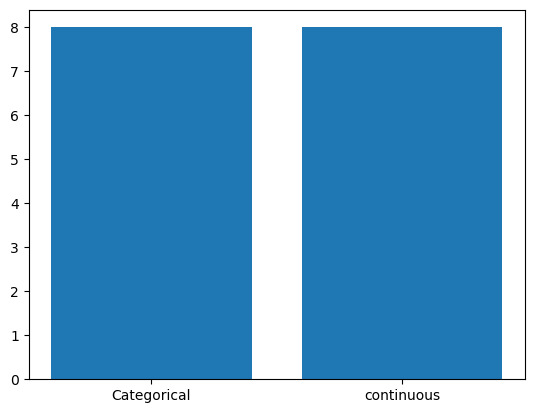

CPU times: total: 125 ms
Wall time: 139 ms


In [5]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in test.columns:
    features.append(feature)
    #print(test.dtypes[feature])
    if test.dtypes[feature]=='int8' or test.dtypes[feature]=='object':
        cat_features.append(feature)
    if test.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [6]:
model = cat.CatBoostClassifier(
    random_state = 14,
    
)

In [7]:
X=train.drop(columns = 'id')
X=X.drop(columns='NObeyesdad')
y=train['NObeyesdad']
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8,test_size = 0.2,random_state = 0)

In [8]:
model.fit(X_train,y_train, cat_features=cat_features)

Learning rate set to 0.091318
0:	learn: 1.6381286	total: 215ms	remaining: 3m 34s
1:	learn: 1.4527804	total: 300ms	remaining: 2m 29s
2:	learn: 1.3176375	total: 391ms	remaining: 2m 10s
3:	learn: 1.2096638	total: 481ms	remaining: 1m 59s
4:	learn: 1.1227076	total: 569ms	remaining: 1m 53s
5:	learn: 1.0521675	total: 653ms	remaining: 1m 48s
6:	learn: 0.9904224	total: 740ms	remaining: 1m 44s
7:	learn: 0.9266759	total: 824ms	remaining: 1m 42s
8:	learn: 0.8760970	total: 918ms	remaining: 1m 41s
9:	learn: 0.8332959	total: 1s	remaining: 1m 39s
10:	learn: 0.7933030	total: 1.09s	remaining: 1m 37s
11:	learn: 0.7576942	total: 1.18s	remaining: 1m 36s
12:	learn: 0.7243775	total: 1.27s	remaining: 1m 36s
13:	learn: 0.6957966	total: 1.36s	remaining: 1m 36s
14:	learn: 0.6709520	total: 1.45s	remaining: 1m 35s
15:	learn: 0.6485357	total: 1.54s	remaining: 1m 34s
16:	learn: 0.6261954	total: 1.63s	remaining: 1m 34s
17:	learn: 0.6078577	total: 1.71s	remaining: 1m 33s
18:	learn: 0.5902674	total: 1.8s	remaining: 1m 

In [9]:
print(model.score(X_valid,y_valid))

0.9041425818882466


In [10]:
model.fit(X,y, cat_features=cat_features)

Learning rate set to 0.092363
0:	learn: 1.6462840	total: 89.8ms	remaining: 1m 29s
1:	learn: 1.4495911	total: 181ms	remaining: 1m 30s
2:	learn: 1.3063479	total: 280ms	remaining: 1m 33s
3:	learn: 1.1893523	total: 376ms	remaining: 1m 33s
4:	learn: 1.1016054	total: 470ms	remaining: 1m 33s
5:	learn: 1.0263618	total: 570ms	remaining: 1m 34s
6:	learn: 0.9626755	total: 663ms	remaining: 1m 34s
7:	learn: 0.9088440	total: 759ms	remaining: 1m 34s
8:	learn: 0.8617750	total: 858ms	remaining: 1m 34s
9:	learn: 0.8186389	total: 958ms	remaining: 1m 34s
10:	learn: 0.7803303	total: 1.08s	remaining: 1m 36s
11:	learn: 0.7454742	total: 1.18s	remaining: 1m 37s
12:	learn: 0.7147110	total: 1.28s	remaining: 1m 37s
13:	learn: 0.6849937	total: 1.4s	remaining: 1m 38s
14:	learn: 0.6614604	total: 1.5s	remaining: 1m 38s
15:	learn: 0.6386216	total: 1.59s	remaining: 1m 37s
16:	learn: 0.6161029	total: 1.69s	remaining: 1m 37s
17:	learn: 0.5983522	total: 1.79s	remaining: 1m 37s
18:	learn: 0.5805629	total: 1.88s	remaining: 

In [11]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,24.437500,1.700195,81.68750,yes,yes,2.000000,2.982422,Sometimes,no,2.763672,no,0.000000,0.976562,Sometimes,Public_Transportation
1,Female,18.000000,1.559570,57.00000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile
2,Female,18.000000,1.711914,50.15625,yes,yes,1.880859,1.412109,Sometimes,no,1.910156,no,0.866211,1.673828,no,Public_Transportation
3,Female,20.953125,1.710938,131.25000,yes,yes,3.000000,3.000000,Sometimes,no,1.673828,no,1.467773,0.780273,Sometimes,Public_Transportation
4,Male,31.640625,1.914062,93.81250,yes,yes,2.679688,1.971680,Sometimes,no,1.979492,no,1.967773,0.931641,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.140625,1.766602,114.18750,yes,yes,2.919922,3.000000,Sometimes,no,2.152344,no,1.330078,0.196655,Sometimes,Public_Transportation
20754,Male,18.000000,1.709961,50.00000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation
20755,Male,20.093750,1.819336,105.56250,yes,yes,2.408203,3.000000,Sometimes,no,2.000000,no,1.158203,1.198242,no,Public_Transportation
20756,Male,33.843750,1.700195,83.50000,yes,yes,2.671875,1.971680,Sometimes,no,2.144531,no,0.000000,0.973633,no,Automobile


In [12]:
test

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.906250,1.848633,120.6250,yes,yes,2.939453,3.000000,Sometimes,no,2.826172,no,0.855469,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.599609,66.0000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643555,111.6250,yes,yes,3.000000,3.000000,Sometimes,no,2.621094,no,0.000000,0.250488,Sometimes,Public_Transportation
3,20761,Male,20.984375,1.552734,103.6875,yes,yes,2.000000,2.978516,Sometimes,no,2.787109,no,0.094849,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.626953,104.8125,yes,yes,3.000000,3.000000,Sometimes,no,2.654297,no,0.000000,0.741211,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.328125,1.721680,78.0000,yes,no,2.812500,3.000000,Sometimes,no,1.000000,no,0.807129,0.778809,Sometimes,Public_Transportation
13836,34594,Female,29.000000,1.589844,62.0000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
13837,34595,Female,22.937500,1.585938,44.3750,no,yes,3.000000,2.273438,Frequently,no,2.000000,no,1.950195,1.000000,Sometimes,Public_Transportation
13838,34596,Male,21.000000,1.620117,53.0000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation


In [13]:
y_preds = model.predict(test.drop(columns='id'))

In [18]:
y_preds.reshape(-1)

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [19]:
df = pd.DataFrame(test['id'])
df["NObeyesdad"] = y_preds.reshape(-1)


In [20]:
df.to_csv('cat_test_submission.csv', index=False)

In [21]:
model2 = cat.CatBoostClassifier(
    random_seed = 42,
    use_best_model = True,
    learning_rate = 0.0115,
    iterations = 5000,
    random_strength = 2
)

In [22]:
model2.fit(X_train,y_train, cat_features=cat_features, eval_set=(X_valid,y_valid))
print(model.score(X_valid,y_valid))

0:	learn: 1.9090393	test: 1.9087881	best: 1.9087881 (0)	total: 95.6ms	remaining: 7m 58s
1:	learn: 1.8746579	test: 1.8745768	best: 1.8745768 (1)	total: 199ms	remaining: 8m 16s
2:	learn: 1.8427707	test: 1.8425635	best: 1.8425635 (2)	total: 290ms	remaining: 8m 2s
3:	learn: 1.8103088	test: 1.8098743	best: 1.8098743 (3)	total: 379ms	remaining: 7m 53s
4:	learn: 1.7785549	test: 1.7780606	best: 1.7780606 (4)	total: 469ms	remaining: 7m 48s
5:	learn: 1.7486126	test: 1.7479341	best: 1.7479341 (5)	total: 568ms	remaining: 7m 52s
6:	learn: 1.7217899	test: 1.7214326	best: 1.7214326 (6)	total: 672ms	remaining: 7m 59s
7:	learn: 1.6942110	test: 1.6938434	best: 1.6938434 (7)	total: 763ms	remaining: 7m 55s
8:	learn: 1.6696629	test: 1.6696100	best: 1.6696100 (8)	total: 850ms	remaining: 7m 51s
9:	learn: 1.6459859	test: 1.6461219	best: 1.6461219 (9)	total: 936ms	remaining: 7m 47s
10:	learn: 1.6225216	test: 1.6226725	best: 1.6226725 (10)	total: 1.04s	remaining: 7m 52s
11:	learn: 1.6016047	test: 1.6019922	best

In [23]:
model2.fit(X,y,cat_features=cat_features, eval_set=(X_valid,y_valid))

0:	learn: 1.9062556	test: 1.9060130	best: 1.9060130 (0)	total: 104ms	remaining: 8m 39s
1:	learn: 1.8705632	test: 1.8701179	best: 1.8701179 (1)	total: 197ms	remaining: 8m 11s
2:	learn: 1.8355051	test: 1.8350524	best: 1.8350524 (2)	total: 287ms	remaining: 7m 57s
3:	learn: 1.8032863	test: 1.8027117	best: 1.8027117 (3)	total: 379ms	remaining: 7m 53s
4:	learn: 1.7712420	test: 1.7706837	best: 1.7706837 (4)	total: 470ms	remaining: 7m 49s
5:	learn: 1.7412344	test: 1.7406379	best: 1.7406379 (5)	total: 562ms	remaining: 7m 47s
6:	learn: 1.7122546	test: 1.7115369	best: 1.7115369 (6)	total: 663ms	remaining: 7m 52s
7:	learn: 1.6875595	test: 1.6868732	best: 1.6868732 (7)	total: 765ms	remaining: 7m 57s
8:	learn: 1.6614236	test: 1.6605186	best: 1.6605186 (8)	total: 862ms	remaining: 7m 58s
9:	learn: 1.6367731	test: 1.6361212	best: 1.6361212 (9)	total: 963ms	remaining: 8m
10:	learn: 1.6117891	test: 1.6110918	best: 1.6110918 (10)	total: 1.05s	remaining: 7m 57s
11:	learn: 1.5886627	test: 1.5879438	best: 1.

In [25]:
y_preds2 = model.predict(test.drop(columns='id'))
df = pd.DataFrame(test['id'])
# df.insert(1,"NObeyesdad",y_preds2)
df["NObeyesdad"] = y_preds2.reshape(-1)
df.to_csv('cat_test_submission2.csv', index=False)

combining original and kaggle

In [26]:
orig = pd.read_csv('dataset/ObesityDataSet.csv')

In [27]:
train_2 = pd.concat([orig, train.drop(columns='id')])

In [28]:
X2 = train_2.drop(columns='NObeyesdad')
y2 = train_2['NObeyesdad']
X_train, X_valid, y_train, y_valid = train_test_split(X2, y2,train_size=0.8,test_size = 0.2,random_state = 0)

In [29]:
model2.fit(X_train,y_train, cat_features=cat_features, eval_set=(X_valid,y_valid))
print(model.score(X_valid,y_valid))

0:	learn: 1.9128141	test: 1.9125228	best: 1.9125228 (0)	total: 86.1ms	remaining: 7m 10s
1:	learn: 1.8760361	test: 1.8755086	best: 1.8755086 (1)	total: 173ms	remaining: 7m 12s
2:	learn: 1.8421755	test: 1.8413111	best: 1.8413111 (2)	total: 262ms	remaining: 7m 16s
3:	learn: 1.8087306	test: 1.8076339	best: 1.8076339 (3)	total: 364ms	remaining: 7m 34s
4:	learn: 1.7782002	test: 1.7770227	best: 1.7770227 (4)	total: 448ms	remaining: 7m 28s
5:	learn: 1.7491618	test: 1.7478620	best: 1.7478620 (5)	total: 536ms	remaining: 7m 26s
6:	learn: 1.7213856	test: 1.7198319	best: 1.7198319 (6)	total: 621ms	remaining: 7m 23s
7:	learn: 1.6936993	test: 1.6922555	best: 1.6922555 (7)	total: 712ms	remaining: 7m 24s
8:	learn: 1.6681717	test: 1.6667518	best: 1.6667518 (8)	total: 804ms	remaining: 7m 26s
9:	learn: 1.6431349	test: 1.6418029	best: 1.6418029 (9)	total: 888ms	remaining: 7m 23s
10:	learn: 1.6202568	test: 1.6188795	best: 1.6188795 (10)	total: 972ms	remaining: 7m 20s
11:	learn: 1.5991689	test: 1.5974002	bes

In [30]:
model2.fit(X2,y2, cat_features=cat_features, eval_set=(X_valid,y_valid))

0:	learn: 1.9089424	test: 1.9084806	best: 1.9084806 (0)	total: 98.7ms	remaining: 8m 13s
1:	learn: 1.8712542	test: 1.8706371	best: 1.8706371 (1)	total: 198ms	remaining: 8m 13s
2:	learn: 1.8395275	test: 1.8387662	best: 1.8387662 (2)	total: 301ms	remaining: 8m 20s
3:	learn: 1.8065514	test: 1.8054903	best: 1.8054903 (3)	total: 402ms	remaining: 8m 22s
4:	learn: 1.7774133	test: 1.7762044	best: 1.7762044 (4)	total: 511ms	remaining: 8m 30s
5:	learn: 1.7485713	test: 1.7472607	best: 1.7472607 (5)	total: 618ms	remaining: 8m 34s
6:	learn: 1.7191656	test: 1.7177958	best: 1.7177958 (6)	total: 722ms	remaining: 8m 34s
7:	learn: 1.6939970	test: 1.6923473	best: 1.6923473 (7)	total: 826ms	remaining: 8m 35s
8:	learn: 1.6666503	test: 1.6648950	best: 1.6648950 (8)	total: 929ms	remaining: 8m 35s
9:	learn: 1.6423436	test: 1.6403360	best: 1.6403360 (9)	total: 1.03s	remaining: 8m 34s
10:	learn: 1.6199923	test: 1.6178562	best: 1.6178562 (10)	total: 1.13s	remaining: 8m 32s
11:	learn: 1.5975477	test: 1.5950858	bes

In [32]:
y_preds3 = model.predict(test.drop(columns='id'))
df = pd.DataFrame(test['id'])
# df.insert(1,"NObeyesdad",y_preds3)
df["NObeyesdad"] = y_preds3.reshape(-1)
df.to_csv('cat_test_submission3.csv', index=False)

In [33]:
model.predict_proba(test.drop(columns='id'))

array([[2.98382492e-05, 8.62954569e-06, 2.65698645e-03, ...,
        7.54805866e-05, 8.16535626e-05, 6.58903049e-04],
       [3.07808085e-05, 1.22072811e-02, 3.01721144e-02, ...,
        2.37626064e-05, 9.34130330e-01, 2.34125262e-02],
       [1.39137475e-06, 6.89630298e-07, 1.71571459e-03, ...,
        9.98191489e-01, 5.01375163e-06, 1.94157673e-05],
       ...,
       [9.59566805e-01, 3.86027600e-02, 1.28678321e-05, ...,
        7.02192515e-06, 1.78446386e-03, 2.45525070e-05],
       [1.85185218e-01, 8.11597535e-01, 3.75957986e-05, ...,
        3.44673041e-06, 2.53234163e-03, 6.38644495e-04],
       [5.22183270e-05, 7.17359392e-06, 3.07572916e-03, ...,
        5.11646379e-05, 1.04603899e-04, 4.66117693e-04]])

In [34]:
model3 = cat.CatBoostClassifier(
    random_seed = 42,
    use_best_model = True,
    learning_rate = 0.0115,
    iterations = 5000,
    random_strength = 2, 
    task_type = 'GPU'
)

In [40]:
X_temp, X_test, y_temp, y_test = train_test_split(X2, y2, test_size = 0.2,random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.1,random_state = 0)

In [41]:
model3.fit(X_train,y_train, cat_features=cat_features, eval_set=(X_valid,y_valid))

0:	learn: 1.9058005	test: 1.9055371	best: 1.9055371 (0)	total: 12.4ms	remaining: 1m 2s
1:	learn: 1.8681496	test: 1.8676607	best: 1.8676607 (1)	total: 24.9ms	remaining: 1m 2s
2:	learn: 1.8330234	test: 1.8324398	best: 1.8324398 (2)	total: 37.2ms	remaining: 1m 1s
3:	learn: 1.7997979	test: 1.7991408	best: 1.7991408 (3)	total: 50.7ms	remaining: 1m 3s
4:	learn: 1.7683091	test: 1.7675773	best: 1.7675773 (4)	total: 62.1ms	remaining: 1m 1s
5:	learn: 1.7381850	test: 1.7373562	best: 1.7373562 (5)	total: 73.8ms	remaining: 1m 1s
6:	learn: 1.7092643	test: 1.7083328	best: 1.7083328 (6)	total: 85.6ms	remaining: 1m 1s
7:	learn: 1.6816918	test: 1.6806713	best: 1.6806713 (7)	total: 98.3ms	remaining: 1m 1s
8:	learn: 1.6554648	test: 1.6543329	best: 1.6543329 (8)	total: 109ms	remaining: 1m
9:	learn: 1.6295099	test: 1.6283156	best: 1.6283156 (9)	total: 121ms	remaining: 1m
10:	learn: 1.6047682	test: 1.6034672	best: 1.6034672 (10)	total: 133ms	remaining: 1m
11:	learn: 1.5814791	test: 1.5801312	best: 1.5801312 

In [42]:
print(model3.score(X_valid,y_valid))

0.9076502732240437


In [43]:
print(model3.score(X_test,y_test))

0.9123305640577175


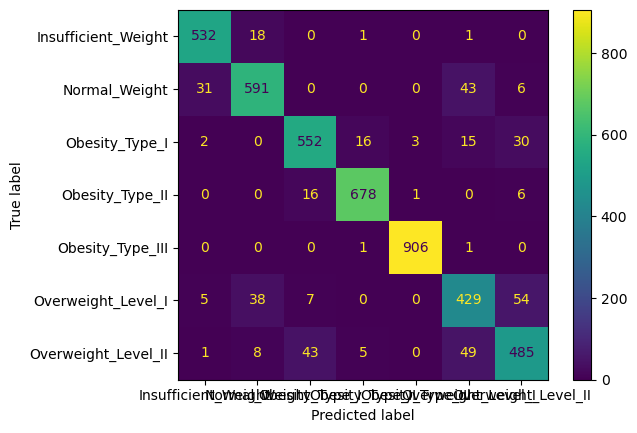

In [45]:
y_preds3 = model3.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds3)